In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

df = pd.read_csv('bank_churn.csv')
df.head()

,ID,active_member,age,credit_score,estimated_salary,products_number,tenure,churn
0,0,0,26,700,50051.420000,2,2,0
1,1,0,47,689,176188.793245,2,3,1
2,2,1,74,617,53949.980000,2,10,0
3,3,0,35,585,13523.872358,1,4,1
4,4,0,50,702,94949.840000,2,3,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                600 non-null    int64  
 1   active_member     600 non-null    int64  
 2   age               600 non-null    int64  
 3   credit_score      600 non-null    int64  
 4   estimated_salary  600 non-null    float64
 5   products_number   600 non-null    int64  
 6   tenure            600 non-null    int64  
 7   churn             600 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 37.6 KB
None
               ID  active_member         age  credit_score  estimated_salary  \
count  600.000000     600.000000  600.000000    600.000000        600.000000   
mean   299.500000       0.386667   41.448333    649.231667     100566.243514   
std    173.349358       0.487393   10.908513     88.941248      59407.396798   
min      0.000000       0.000000   20.000000    35

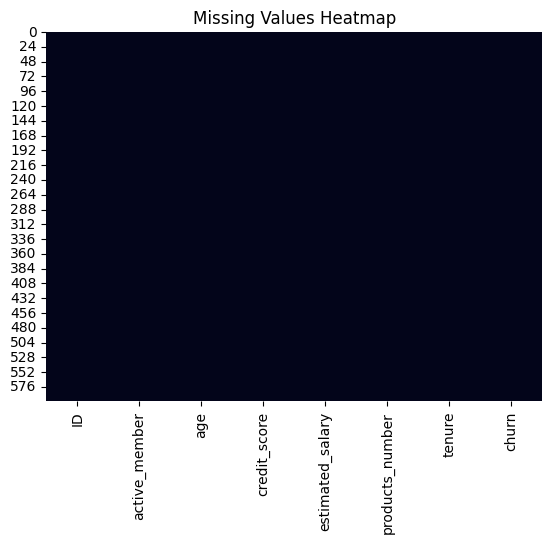

In [2]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [3]:
label_encoders = {}
for col in df.select_dtypes(include='object'):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,ID,active_member,age,credit_score,estimated_salary,products_number,tenure,churn
0,0,0,26,700,50051.420000,2,2,0
1,1,0,47,689,176188.793245,2,3,1
2,2,1,74,617,53949.980000,2,10,0
3,3,0,35,585,13523.872358,1,4,1
4,4,0,50,702,94949.840000,2,3,0


In [5]:
possible_targets = ['Exited', 'exited', 'Churn', 'churn', 'Label', 'label', 'ExitedCustomer', 'target']

target_col = None
for col in df.columns:
    if col in possible_targets:
        target_col = col
        break

print("Detected Target Column:", target_col)

X = df.drop(target_col, axis=1)
y = df[target_col]

Detected Target Column: churn


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

In [9]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7416666666666667


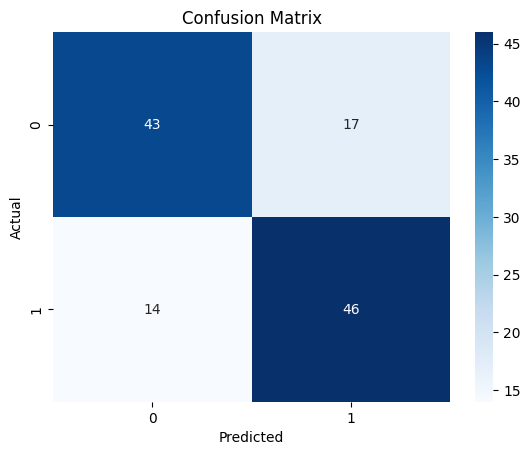

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74        60
           1       0.73      0.77      0.75        60

    accuracy                           0.74       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.74      0.74      0.74       120



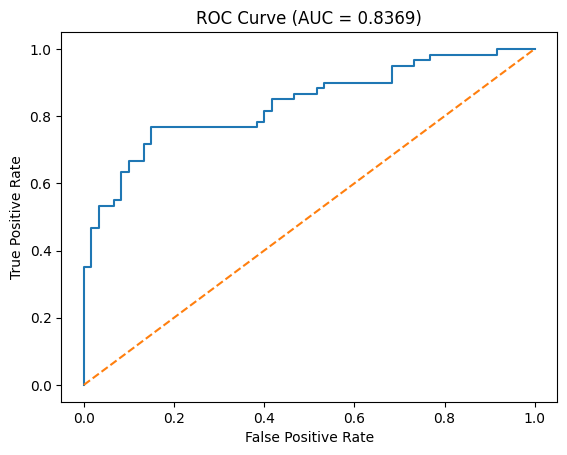

In [12]:
y_probs = log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title(f"ROC Curve (AUC = {auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [13]:
importance = log_reg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

            Feature  Importance
2               age    0.829851
4  estimated_salary    0.091646
3      credit_score    0.031054
0                ID   -0.046659
6            tenure   -0.182680
5   products_number   -0.460949
1     active_member   -1.085319


In [15]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=3000))
])

cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')

print("CV Mean Accuracy:", cv_scores.mean())
print("CV Scores:", cv_scores)


CV Mean Accuracy: 0.72
CV Scores: [0.7        0.76666667 0.71666667 0.71666667 0.75       0.7
 0.65       0.7        0.75       0.75      ]


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3518 - loss: 0.8468 - val_accuracy: 0.3646 - val_loss: 0.8179
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3603 - loss: 0.8468 - val_accuracy: 0.3646 - val_loss: 0.8092
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3414 - loss: 0.8432 - val_accuracy: 0.3646 - val_loss: 0.8011
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3831 - loss: 0.8124 - val_accuracy: 0.3646 - val_loss: 0.7934
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3820 - loss: 0.8049 - val_accuracy: 0.3750 - val_loss: 0.7856
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3881 - loss: 0.8029 - val_accuracy: 0.3750 - val_loss: 0.7781
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4085 - loss: 0.7726 - val_accuracy: 0.3750 - val_loss: 0.7712
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3564 - loss: 0.7969 - val_accuracy: 0.3750 - val_loss: 0.7638
Ep

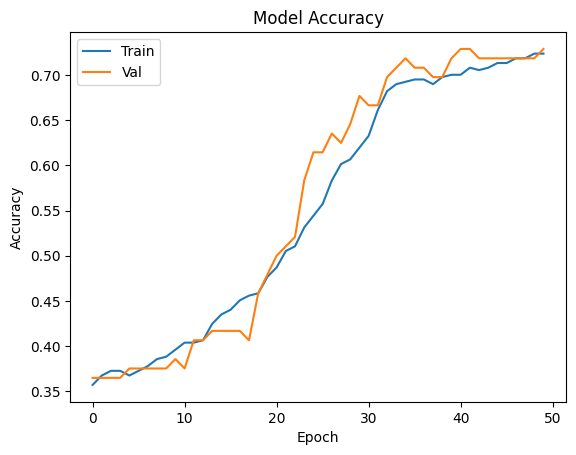

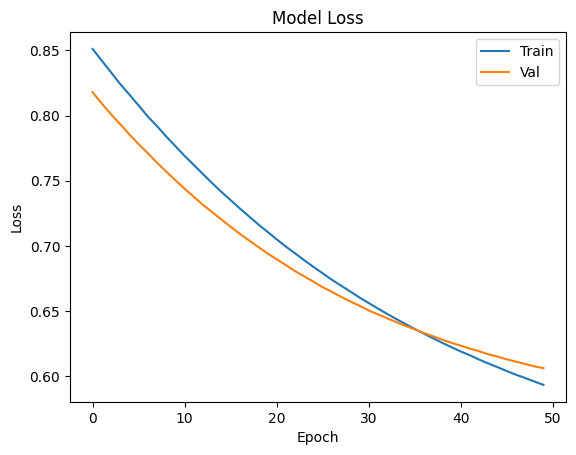

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [18]:
keras_preds = model.predict(X_test)
keras_preds = (keras_preds > 0.5).astype(int)

print("Keras Model Accuracy:", accuracy_score(y_test, keras_preds))
print(confusion_matrix(y_test, keras_preds))
print(classification_report(y_test, keras_preds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Keras Model Accuracy: 0.7166666666666667
[[43 17]
 [17 43]]
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        60
           1       0.72      0.72      0.72        60

    accuracy                           0.72       120
   macro avg       0.72      0.72      0.72       120
weighted avg       0.72      0.72      0.72       120

